In [14]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
from data import monet_jpg, photo_jpg
import matplotlib.pyplot as plt
import numpy as np

print(sys.path)

['c:\\Users\\a02185015\\DL-Final-Project', 'c:\\Program Files\\Python310\\python310.zip', 'c:\\Program Files\\Python310\\DLLs', 'c:\\Program Files\\Python310\\lib', 'c:\\Program Files\\Python310', '', 'C:\\Users\\a02185015\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\a02185015\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32', 'C:\\Users\\a02185015\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\a02185015\\AppData\\Roaming\\Python\\Python310\\site-packages\\Pythonwin', 'c:\\Program Files\\Python310\\lib\\site-packages']


In [15]:
batch_size = 8

# read in data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

jpg_path = "C/Users/a02185015/DL-Final-Project/data/"

#show a few images

jpg_photos = datasets.ImageFolder(root='data_jpg/', transform=transform)

print(jpg_photos.classes)

image_loader = DataLoader(jpg_photos, batch_size=batch_size, shuffle=False)

# photo_images = datasets.ImageFolder(root='photo/', transform=transform)
# monet_images = datasets.ImageFolder(root='monet/', transform=transform)

# photo_loader = DataLoader(photo_images, batch_size=batch_size, shuffle=True)
# monet_loader = DataLoader(monet_images, batch_size=batch_size, shuffle=True)

['monet_jpg', 'photo_jpg']


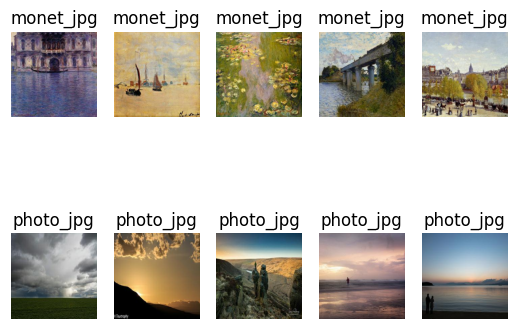

In [16]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# Get a batch of images
dataiter = iter(image_loader)
images, labels = next(dataiter)

# Initialize counters
counters = {class_name: 0 for class_name in jpg_photos.classes}

# Create a figure for the subplots
fig, axs = plt.subplots(2, 5)

# Iterate over the DataLoader
for images, labels in image_loader:
    for i in range(images.size(0)):
        # If we have printed 5 images from each class, stop
        if all(count >= 5 for count in counters.values()):
            break

        # Get the class name of the current image
        class_name = jpg_photos.classes[labels[i]]

        # If we have not printed 5 images from this class yet, add it to the subplot
    if counters[class_name] < 5:
        img = images[i] / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        axs[jpg_photos.class_to_idx[class_name], counters[class_name]].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[jpg_photos.class_to_idx[class_name], counters[class_name]].set_title(class_name)
        axs[jpg_photos.class_to_idx[class_name], counters[class_name]].axis('off')
        counters[class_name] += 1

    # If we have printed 5 images from each class, stop
    if all(count >= 5 for count in counters.values()):
        break

plt.show()

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used for modeling: ", device)

Device used for modeling:  cuda


In [18]:
def imshow(img):
    img = img.cpu() / 2 + 0.5  # unnormalize and move to cpu
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [19]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        # print("img_size: ", img_size)

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(inplace=True),
        )
        
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),  # Adjust padding
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Adjust padding
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=1, padding=1),  # Adjust padding
            nn.Tanh()
        )

    def forward(self, z):
        # print("z: ", z.shape)
        x = self.model(z)
        # print("x: ", x.shape)
        x = x.view(-1, 128, self.img_size // 4, self.img_size // 4)
        # print("x: ", x.shape)
        x = self.deconv_layers(x)
        # print("x: ", x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256*32*32, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        # print("Discriminator")
        # print("img: ", img.shape)
        img = self.model(img)
        # print("img: ", img.shape)
        return img

# Hyperparameters
latent_dim = 100
channels = 3  # for color images
img_size = 256

# Initialize generator and discriminator
generator = Generator(latent_dim, channels, img_size)
discriminator = Discriminator(channels, img_size)

# Print the models
print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=524288, bias=True)
    (1): ReLU(inplace=True)
  )
  (deconv_layers): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [21]:
# Hyperparameters
batch_size = 64
lr = 0.0002
epochs = 100

generator = Generator(latent_dim, channels, img_size).to(device)
discriminator = Discriminator(channels, img_size).to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# # Training loop
# print(f'Training starting... {epochs} epochs')
# for epoch in range(epochs):
#     for i, (images, labels) in enumerate(image_loader):
#         # Adversarial ground truths
#         valid = torch.ones((images.size(0), 1), requires_grad=False).to(device)
#         fake = torch.zeros((images.size(0), 1), requires_grad=False).to(device)

#         # Move data to device
#         images = images.to(device)

#         # Train Generator
#         optimizer_G.zero_grad()
#         z = torch.randn((images.size(0), latent_dim)).to(device)
#         gen_images = generator(z)
#         # print(f'Shape after going through generator {gen_images.shape}')
#         g_loss = adversarial_loss(discriminator.forward(gen_images), valid)
#         g_loss.backward()
#         optimizer_G.step()

#         # Train Discriminator
#         optimizer_D.zero_grad()
#         real_loss = adversarial_loss(discriminator(images), valid)
#         fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)
#         d_loss = (real_loss + fake_loss) / 2
#         d_loss.backward()
#         optimizer_D.step()

#         # Print progress
#         if i % 1 == 0:
#             print(
#                 "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                 % (epoch, epochs, i, len(image_loader), d_loss.item(), g_loss.item())
#             )

#          # Print progress and show images
#         if i % 10 == 0:  # adjust this to show images less or more often
#             print(
#                 "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                 % (epoch, epochs, i, len(image_loader), d_loss.item(), g_loss.item())
#             )

#             print("Real Images")
#             imshow(utils.make_grid(images[:5], nrow=5, normalize=True))
#             print("Generated Images")
#             imshow(utils.make_grid(gen_images[:5].detach(), nrow=5, normalize=True))

#     # Save generated images at the end of each epoch
#     if epoch % 10 == 0:
#         # Note: Adjust the save path and naming according to your preference
#         torch.utils.save_image(gen_images.data[:25], f"images/generated_epoch_{epoch}.png", nrow=5, normalize=True)

# # Training loop
# print(f'Training starting... {epochs} epochs')
# for epoch in range(epochs):
#     for i, (monet_paintings, labels) in enumerate(image_loader):  # assuming image_loader loads Monet paintings
#         # Adversarial ground truths
#         valid = torch.ones((monet_paintings.size(0), 1), requires_grad=False).to(device)
#         fake = torch.zeros((monet_paintings.size(0), 1), requires_grad=False).to(device)

#         # Move data to device
#         monet_paintings = monet_paintings.to(device)

#         # Train Generator
#         optimizer_G.zero_grad()
#         z = torch.randn((monet_paintings.size(0), latent_dim)).to(device)
#         gen_images = generator(z)
#         g_loss = adversarial_loss(discriminator(gen_images), valid)  # Trying to make generated images appear valid
#         g_loss.backward()
#         optimizer_G.step()

#         # Train Discriminator
#         optimizer_D.zero_grad()
#         real_loss = adversarial_loss(discriminator(monet_paintings), valid)  # Monet paintings labeled as valid
#         fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)  # Generated images labeled as fake
#         d_loss = (real_loss + fake_loss) / 2
#         d_loss.backward()
#         optimizer_D.step()

#         # Print progress and show images
#         if i % 10 == 0:  # adjust this to show images less or more often
#             print(
#                 "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                 % (epoch, epochs, i, len(image_loader), d_loss.item(), g_loss.item())
#             )

#             print("Photo Images")
#             imshow(utils.make_grid(monet_paintings[:5], nrow=5, normalize=True))
#             print("Generated Monet Painting")
#             imshow(utils.make_grid(gen_images[:5].detach(), nrow=5, normalize=True))

#Training loop
for epoch in range(epochs):
    for i, (images, labels) in enumerate(image_loader):
        # Separate Monet paintings and photos based on labels
        monet_paintings = images[0].to(device)
        photos = images[1].to(device)

        # Check if there are any Monet paintings or photos in the current batch
        if monet_paintings.size(0) == 0 or photos.size(0) == 0:
            print('they are empty')
            break

        # print(monet_paintings.shape)
        # print(monet_paintings)

        # Adversarial ground truths
        valid = torch.ones((monet_paintings.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((photos.size(0), 1), requires_grad=False).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        # z = torch.randn((photos.size(0), latent_dim)).to(device)
        gen_images = generator(photos)
        g_loss = adversarial_loss(discriminator(gen_images), valid)  # Trying to make generated images appear valid
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        # optimizer_D.zero_grad()
        # monet_paintings = images[0].unsqueeze(0).to(device)
        # print(f'Shape of monet_paintings {monet_paintings.shape}')
        # real_loss = adversarial_loss(discriminator(monet_paintings), valid)  # Monet paintings labeled as valid
        # fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)  # Generated images labeled as fake
        # d_loss = (real_loss + fake_loss) / 2
        # d_loss.backward()
        # optimizer_D.step()

        optimizer_D.zero_grad()
        monet_paintings = images[0].unsqueeze(0).to(device)
        valid = torch.ones((monet_paintings.size(0), 1), requires_grad=False).to(device)
        real_loss = adversarial_loss(discriminator(monet_paintings), valid)  # Monet paintings labeled as valid
        fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)  # Generated images labeled as fake
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress and show images
        if i % 100 == 0:  # adjust this to show images less or more often
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(image_loader), d_loss.item(), g_loss.item())
            )

            print("Monet Paintings")
            imshow(utils.make_grid(monet_paintings[:5], nrow=5, normalize=True))
            print("Generated Images")
            imshow(utils.make_grid(gen_images[:5].detach(), nrow=5, normalize=True))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (768x256 and 100x524288)

In [ ]:
# import torch.nn as nn

# # Define the Generator
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(64 * 8),
#             nn.ReLU(True),
#             # state size. (64*8) x 4 x 4
#             nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 4),
#             nn.ReLU(True),
#             # state size. (64*4) x 8 x 8
#             nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 2),
#             nn.ReLU(True),
#             # state size. (64*2) x 16 x 16
#             nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             # state size. (64) x 32 x 32
#             nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (3) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

# # Define the Discriminator
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # input is (3) x 64 x 64
#             nn.Conv2d(3, 64, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64) x 32 x 32
#             nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64*2) x 16 x 16
#             nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64*4) x 8 x 8
#             nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64*8) x 4 x 4
#             nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)